# Use Case Complex Images : Aptos

**Introduction:**

Welcome to HES-Xplain, our interactive platform designed to facilitate explainable artificial intelligence (XAI) techniques. In this use case, we dive into sport image classification and showcase the utility of eXplainable AI (XAI) in this domain. We will focus on applying tools available on our platform to interpret and understand the decisions made by a Convolutional Neural Network (CNN) model.

We also provide scripts, conveniently customizable, facilitate data loading, model training and evaluation, and performance metric plotting. Located in the scripts folder of this repository, they feature clear annotations to aid comprehension and instructions for effortless adaptation to your specific model needs.

We will go through some state of the art XAI techniques for CNN models and some tools that wer designed by our team such as Rules Extraction or Fuzzy Logic. To do this we will use a pre-trained model, a diabetic retinopathy detection dataset, and HES-XPLAIN to interpret the model's predictions.

**Objectives:**

1. Understand the importance of interpretability in image classification.
2. Introduce XAI techniques to interpret classification and understand a CNN model.
3. Showcase the capabilities of HES-XPLAIN. 
4. Provide practical insights into applying such techniques through an interactive notebook.
5. Foster a community of XAI enthusiasts and practitioners.

**Outline:**

1. Dataset and Problem Statement.
2. Model Architecture.
3. Modeling, training, and evaluation.


## Google Colab Setup

This section prepares the notebook for use with Google Colaboratory. If applicable, change the following variable to **True**:

In [1]:
# Colab compatibility
use_colab = False

Prepare the code by downloading the code and installing required packages.

In [2]:
if use_colab:
    # ensure the directory is empty
    !rm -rf * .config

    !# install codebase from GitHub
    !git clone --no-checkout https://github.com/HES-XPLAIN/notebooks.git --depth=1 .
    !git config core.sparseCheckout true
    !git sparse-checkout set --cone
    !git sparse-checkout add use_case_sport_classification
    !git sparse-checkout reapply
    !git checkout main

    # adjust folder structure
    !mv use_case_aptos/* .
    !rm -rf use_case_aptos/

In [3]:
if use_colab:
    # Install dependencies
    !pip install git+https://github.com/salesforce/OmniXAI.git@v1.3.2

When asked to, restart the session by clicking on the "Restart Session" button, then continue and execute the next cells.

## Workspace Setup

This section download the required code and models from our GitHub and huggingface.co repositories.

Download the model weight.

In [5]:
!mkdir -p models_weight
!curl -OL https://huggingface.co/HES-XPLAIN/VGGAptos/resolve/main/VGGAptos.pth -o VGGAptos.pth
!curl -OL https://huggingface.co/HES-XPLAIN/VGGAptos/resolve/main/VGGAptos.pth -o VGGAptos_augmented.pth
!mv *.pth models_weight/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1121  100  1121    0     0   4889      0 --:--:-- --:--:-- --:--:--  4895
100  512M  100  512M    0     0   102M      0  0:00:04  0:00:04 --:--:--  110M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1123  100  1123    0     0   5713      0 --:--:-- --:--:-- --:--:--  5729
100  512M  100  512M    0     0   101M      0  0:00:05  0:00:05 --:--:--  107M


---
## Dataset and Problem Statement

The APTOS 2019 retina classification dataset utilized in this use case comprises approximately 3,662 images, encompassing a range of severity levels for diabetic retinopathy. This dataset, accessible on [Kaggle](https://www.kaggle.com/competitions/aptos2019-blindness-detection/), includes a total of 3,662 images, which are categorized into five severity levels of diabetic retinopathy (DR).
The five classification categories are : 
- No DR
- Mild
- Moderate
- Server
- Proliferative DR

**Problem Statement:** The goal is to develop a reliable image classifier capable of accurately diagnosing the severity of diabetic retinopathy from retina images. The dataset's focus on varying stages of this condition makes it ideal for applying and demonstrating XAI techniques. By employing deep learning models and XAI techniques, the objective is not only to achieve superior classification accuracy but also to understand the key regions within the retina images that influence the classification decisions.

In [3]:
# global imports
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from PIL import Image
from scripts.helpers import *

from torch.utils.data import DataLoader

In [4]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [5]:
# set global variables

home_path = "./"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

idx2class = {
    0: 'No DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}

class2idx = {
    'No DR': 0,
    'Mild': 1,
    'Moderate': 2,
    'Severe': 3,
    'Proliferative DR': 4
}

### Load the Model

In this use case, we leverage the power of transfer learning and fine-tuning by utilizing a pre-trained model. Specifically, we will be using a fine-tuned VGG model that have already learned valuable features from a large-scale dataset. To perform inference with this model, we will need to include the model class definition script.

**Class Definition Script:**

You can find the class definition script (`model.py`) in the `scripts` directory of this notebook that define a VGG model. You can create a similar class with the model of your needs,  just make sure to adapt it to the number of classes of your dataset, here it is 5 classes. 

The script contains the necessary custom class definitions and functions required for the sport image classification task. Make sure to include and import this script in your code to ensure proper model instantiation and inference.

To load the fine-tuned weights into the model, you can use the following code snippet:

```python
import torch
from scripts.model import YourCustomModelClass

# Create an instance of your PyTorch model
model = YourCustomModelClass()

# Load the fine-tuned weights into the model
model.load_state_dict(torch.load("path_to_your_fine_tuned_weights.pth"))

# Set the model to evaluation mode
model.eval()

# Perform inference using the model
# ...

In [6]:
from scripts.model import VGGAptos

model = VGGAptos()
model.load_state_dict(torch.load('./models_weight/VGGAptos_1908_v2.pth',  map_location=device))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/arthurbabey/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 113MB/s]  


<All keys matched successfully>

### Model Architecture

For now, we will utilize the VGG16 architecture, which has demonstrated excellent performance in image classification tasks. VGG16 models are known for their simplicity and effectiveness, making them widely used in various computer vision applications.

VGG16 consists of several convolutional layers followed by fully connected layers. The architecture is characterized by its deep stack of convolutional layers, which allows it to learn complex features from input images.

In our case, we will use the VGG16 model with the following specifications:

- Model: VGG16
- Pretrained: Yes
- Number of classes: 100

VGG16 is a well-established model in the computer vision community and has been pretrained on large-scale image datasets like ImageNet. By leveraging transfer learning and fine-tuning, we can utilize the pre-trained weights of VGG16 to enhance our model's performance on the sport image classification task.

In [7]:
model

VGGAptos(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

### Traininig

As previously described, we've loaded a pretrained model that underwent fine-tuning. However, if desired, you have the option to further fine-tune it using either our train scripts or the train functions provided, both defined in ./scripts/train.py. As we can't direclty provide an access to the dataset you will need to download the APTOS 2019 dataset and place it in a folder /data to match the script requirements before using it. 

In [15]:
# TO DO

# using the script 
#!python scripts/train.py --epochs 100 --lr 1e-4 --name CustomName

# or using the function 
# from scripts.train
# and use it as you needs

### Evaluation

To evaluate the performance of the model on the evaluation dataset, let's have a look at the pre-computed confusion matrix and see what is interesing. Once again you can compute it yourself alone or using the functions given in the scripts/helpers.py file. Here we plot a pre-computed matrix since we can not provide the test set directly. 

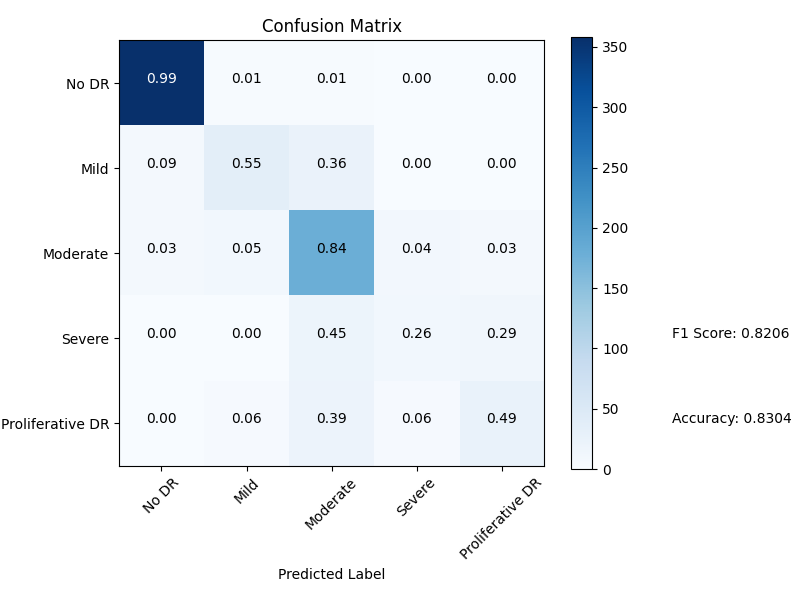

In [10]:
from PIL import Image

# Open and display the image
img = Image.open('plots/confusion_matrixVGGAptos_1908_v2.png')
img


#### Understanding the Confusion Matrix: A Case Study

In our confusion matrix, we notice that the "No DR" category is classified very accurately, with more than 99% of samples correctly identified. This high accuracy is likely because "No DR" is a clear and dominant category in our dataset. 

However, we observe that the other categories, like "Moderate DR," "Mild DR," "Severe DR," and "Proliferative DR," show varied levels of accuracy. For example:

- "Moderate DR" has a reasonable accuracy of about 0.84.
- "Severe" shows a very bad accuracy of 0.26.

What’s particularly surprising is that the model seems to mistakenly classify many samples as "Moderate DR," even when they belong to "Mild," "Severe," or "Proliferative DR." Specifically, 36% of "Mild" samples and 45% of "Severe" samples are misclassified as "Moderate." This is a notable issue.

Looking at the number of samples in the original dataset (see the plot below) we find that the "Moderate" category is overrepresented compared to the other categories, except "No DR." This overrepresentation might explain why the model tends to favor the "Moderate DR" classification.


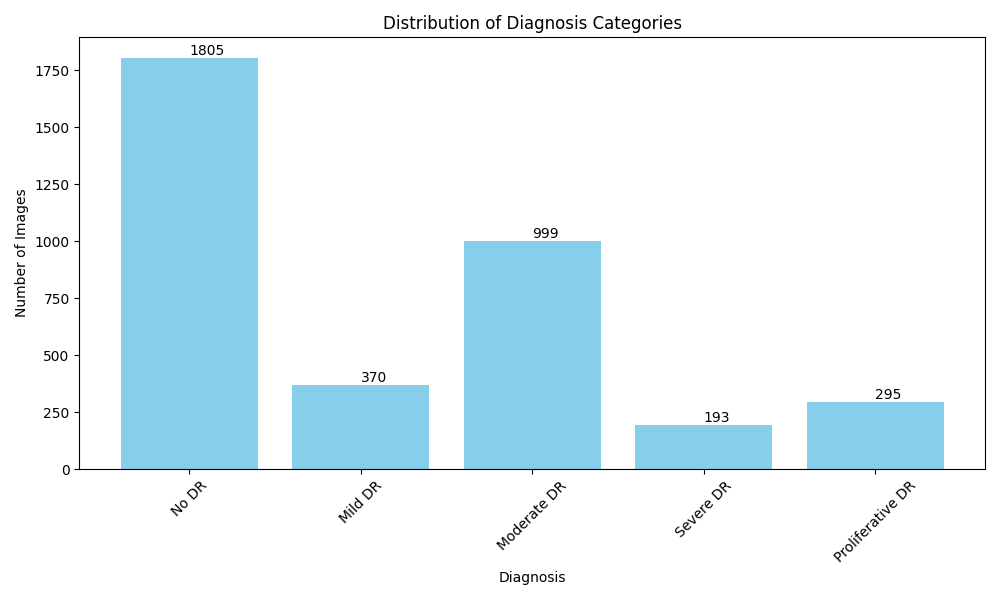

In [11]:
# Open and display the image
img = Image.open('plots/bar_plot_classname.png')
img


To improve our model, we can retrain it with adjustments for these dataset imbalances in order to remove this sampling bias. 
To do this we randomly selected No DR to select only 1k images and using random image transformations we increase the number of samples per catergory to reach 1k as shown below. 

Additionally, we can use Explainable AI (XAI) techniques to better understand where the model is making mistakes and why. This approach will help us enhance the model's performance and make it more accurate across all categories.

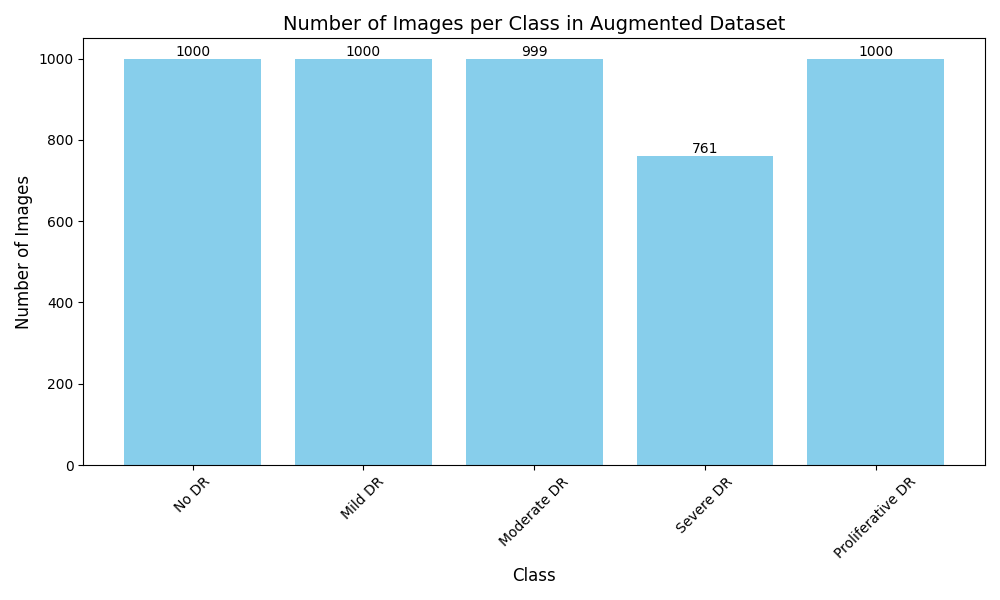

In [12]:
img = Image.open('plots/bar_plot_classname_balanced.png')
img

### Balancing the dataset 

Now we can use this balanced dataset to fine tune our VGG model. And hopefully we will get rid of most effect due to imbalance data.

In [14]:
model_balanced = VGGAptos()
model_balanced.load_state_dict(torch.load('./models_weight/VGG_augmented_1908_v2.pth'))

<All keys matched successfully>

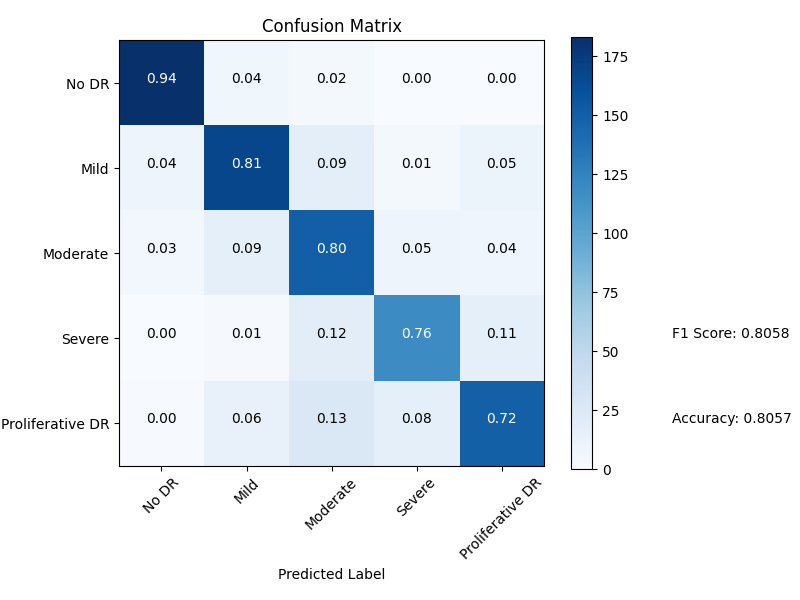

In [15]:
# Open and display the image
img = Image.open('plots/confusion_matrixVGG_augmented_1908_v2.png')
img


#### Model Evaluation and Next Steps

After retraining our model on a balanced dataset, we observed some interesting results:

- **F1 Score and Accuracy**: While the overall F1 score and accuracy haven't improved significantly and eveng get slightly worse, the confusion matrix shows a noticeable improvement. Now, all categories are classified with an accuracy of more than 0.72.
- **Category-Specific Performance**: There is a slight 4% drop in the accuracy for the "No DR" category. However, this decrease is offset by improvements in the accuracy of other categories.
- **Current Model Status**: Our model, trained on a balanced dataset, now provides more consistent and coherent classifications across different categories.

Despite these improvements, there are still instances of incorrect classifications. To further enhance our model and understand its behavior better, the next step is to use Explainable AI (XAI) techniques. XAI will help us:

1. **Make the Model More Understandable**: By using XAI, we can gain insights into how the model makes decisions.
2. **Identify Potential Biases**: XAI can also help us spot any remaining biases or issues in the model.

This approach will guide us in refining the model further and ensuring its predictions are as accurate and fair as possible.

---
Looking into the confusion matrix we can see that the worse classified category is "proliferative DR" which could be problematic since it is the worse condition category. We can see that 13% of the Profliferative DR are predicted as Moderate which is surprising because they are not neighbours category, let's try to find out what our model is doing wrong here. 